In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek, month, from_unixtime, when, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import DoubleType, IntegerType

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [16]:
spark = SparkSession.builder.appName("RedditTimingAnalysis").getOrCreate()

In [17]:
df = spark.read.csv("gs://us-central1-cs131-practice-8a9f773e-bucket/data/submissions.csv", header=True, inferSchema=True)

In [18]:
# Convert timestamp and extract features
df = df.withColumn("datetime", from_unixtime("unixtime"))
df = df.withColumn("hour", hour("datetime").cast(IntegerType()))
df = df.withColumn("day_of_week", dayofweek("datetime").cast(IntegerType()))
df = df.withColumn("month", month("datetime").cast(IntegerType()))

In [19]:
# Handle division safely
df = df.withColumn("upvote_ratio", when(col("total_votes") != 0, col("score") / col("total_votes")).otherwise(0))
# Ensure score is numeric
df = df.withColumn("score", col("score").cast(DoubleType()))
# Drop rows with nulls before ML
df_clean = df.na.drop(subset=["hour", "day_of_week", "month", "score"])

In [20]:
# Feature engineering for ML
feature_cols = ["hour", "day_of_week", "month"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
df_features = assembler.transform(df_clean)

In [21]:
# ML analysis
lr = LinearRegression(featuresCol="features", labelCol="score")
lr_model = lr.fit(df_features)
print(f"Coefficients: {lr_model.coefficients}")

25/05/10 22:32:20 WARN Instrumentation: [8b70b63b] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [0.18040361532922053,0.463968513417503,-13.247974754219557]


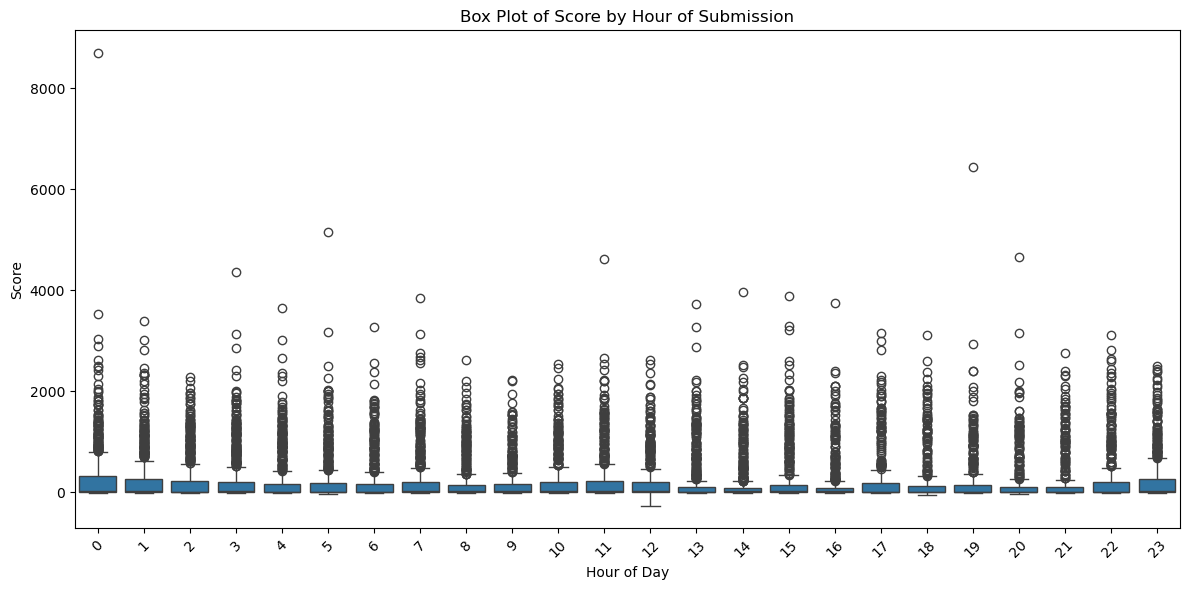

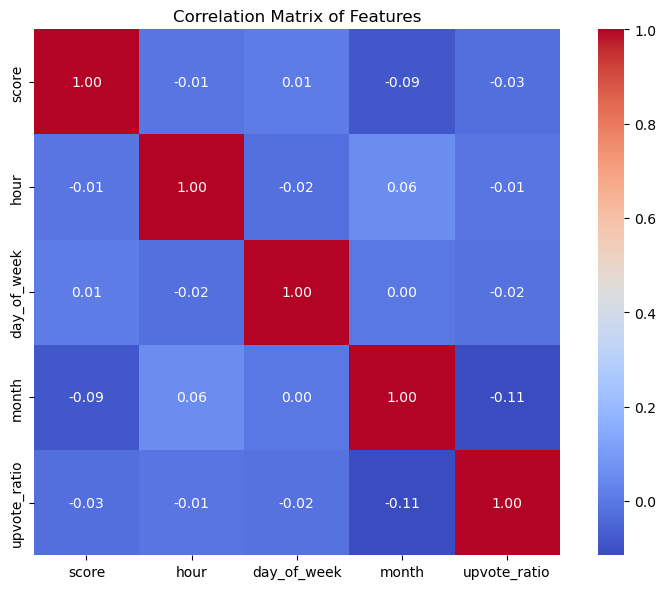

In [24]:
# Convert to pandas for plotting
pdf = df_clean.select("score", "hour", "day_of_week", "month", "upvote_ratio").sample(False, 0.1).toPandas()

# --- Visualization 1: Box Plot of Score by Hour ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="hour", y="score", data=pdf)
plt.title("Box Plot of Score by Hour of Submission")
plt.xlabel("Hour of Day")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Visualization 2: Correlation Matrix ---
plt.figure(figsize=(8, 6))
corr = pdf.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()